# Academic Paper Virality: An Agent-Based Model

> Computational Analysis of Social Complexity

**Prerequisites**
- ABM concepts
- Basic network analysis
- Data manipulation with DataFrames

**Outcomes**
- Build an ABM using real-world data
- Model citation dynamics in academic networks
- Analyze emergence of "viral" papers and sleeping beauties

**References**
- ArXiv Dataset: https://www.kaggle.com/datasets/Cornell-University/arxiv
- Citation Network Tools: https://github.com/mattbierbaum/arxiv-public-datasets

## Overview

- Academic papers spread through citation networks
- Some papers go "viral" quickly, others are "sleeping beauties" that gain citations years later
- We'll model how papers gain citations based on:
    - Author prestige
    - Topic trends
    - Network position
    - Quality/novelty

## Part 1: Data Collection & Exploration

### Setup and Dependencies

In [1]:
using Pkg
Pkg.add(["JSON3", "Downloads", "CSV", "DataFrames", "Graphs", "Agents", "Random", "Statistics", "CairoMakie", "ProgressMeter", "StatsBase"])

   Resolving package versions...
  No Changes to `~/Teaching/UCF/CAP-6318/book-myst/week07/Project.toml`
  No Changes to `~/Teaching/UCF/CAP-6318/book-myst/week07/Manifest.toml`
Precompiling project...
    780.9 ms  ✓ QOI
    967.1 ms  ✓ ImageAxes
    975.7 ms  ✓ OpenEXR
   1276.3 ms  ✓ WebP
   1496.0 ms  ✓ Sixel
   1628.4 ms  ✓ JpegTurbo
    946.9 ms  ✓ ImageMetadata
   1185.6 ms  ✓ Netpbm
   9745.8 ms  ✓ TiffImages
  9 dependencies successfully precompiled in 11 seconds. 325 already precompiled.


In [2]:
using JSON3
using Downloads
using CSV
using DataFrames
using Graphs
using Agents
using Random
using Statistics
using CairoMakie
using Dates
using StatsBase

### Download Sample ArXiv Data

For this example, we'll work with a subset of ArXiv papers. In practice, you would download the full dataset from Kaggle.

In [3]:
# For demonstration, we'll create synthetic data that mimics ArXiv structure
# In practice, download from: https://www.kaggle.com/datasets/Cornell-University/arxiv

function create_sample_arxiv_data(n_papers=1000, n_authors=300)
    Random.seed!(42)

    # Create authors with varying prestige
    authors = DataFrame(
        author_id = 1:n_authors,
        name = ["Author_$i" for i in 1:n_authors],
        h_index = rand(1:50, n_authors),
        institution_rank = rand(1:100, n_authors)
    )

    # Create papers
    papers = DataFrame()
    papers.paper_id = 1:n_papers
    papers.title = ["Paper_$i" for i in 1:n_papers]
    papers.year = rand(2010:2023, n_papers)
    papers.month = rand(1:12, n_papers)
    papers.category = rand(["cs.AI", "cs.LG", "stat.ML", "physics", "math"], n_papers)
    papers.abstract_length = rand(100:500, n_papers)
    papers.n_authors = rand(1:5, n_papers)
    papers.lead_author_id = rand(1:n_authors, n_papers)
    papers.quality_score = rand(n_papers)  # Hidden variable representing paper quality

    # Create citation network (papers cite older papers)
    citations = DataFrame(citing_paper=Int[], cited_paper=Int[], citation_year=Int[])

    for i in 1:n_papers
        paper_year = papers.year[i]
        # Papers can only cite older papers
        older_papers = findall(papers.year .< paper_year)
        if length(older_papers) > 0
            n_citations = min(rand(0:20), length(older_papers))
            if n_citations > 0
                cited = sample(older_papers, n_citations, replace=false)
                for c in cited
                    push!(citations, (i, c, paper_year + rand(0:2)))
                end
            end
        end
    end

    return papers, authors, citations
end

papers_df, authors_df, citations_df = create_sample_arxiv_data()
println("Generated $(nrow(papers_df)) papers, $(nrow(authors_df)) authors, $(nrow(citations_df)) citations")

Generated 1000 papers, 300 authors, 9527 citations


### Explore the Data

In [4]:
# Show sample of papers
first(papers_df, 5)

Row,paper_id,title,year,month,category,abstract_length,n_authors,lead_author_id,quality_score
,Int64,String,Int64,Int64,String,Int64,Int64,Int64,Float64
1,1,Paper_1,2022,11,physics,152,2,27,0.158341
2,2,Paper_2,2019,4,cs.LG,133,3,260,0.843125
3,3,Paper_3,2014,5,cs.AI,136,1,269,0.68607
4,4,Paper_4,2012,3,math,302,3,15,0.830427
5,5,Paper_5,2018,2,cs.AI,483,2,205,0.551647


In [5]:
# Citation statistics
citation_counts = combine(groupby(citations_df, :cited_paper), nrow => :n_citations)
describe(citation_counts.n_citations)

Summary Stats:
Length:         870
Missing Count:  0
Mean:           10.950575
Std. Deviation: 9.427262
Minimum:        1.000000
1st Quartile:   3.250000
Median:         8.000000
3rd Quartile:   15.000000
Maximum:        47.000000
Type:           Int64


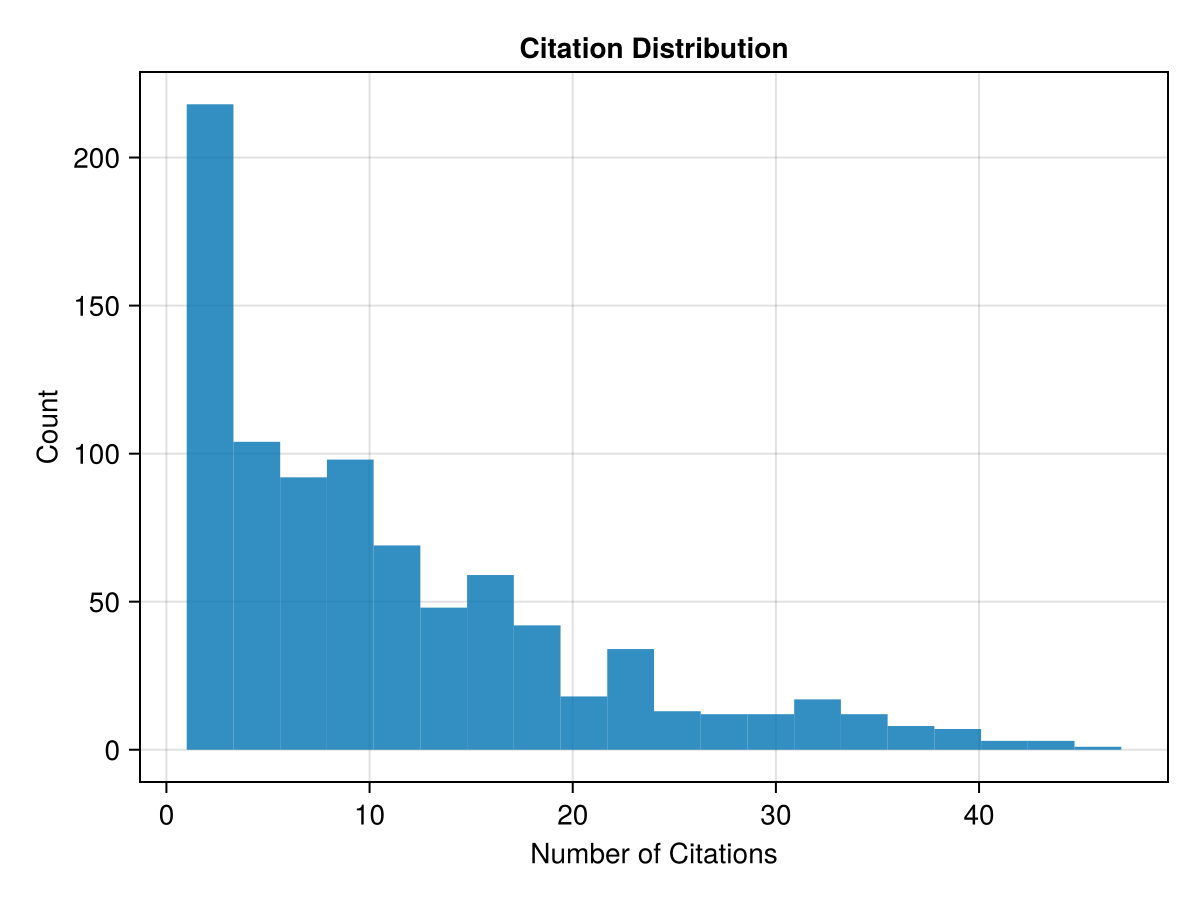

In [6]:
# Visualize citation distribution (classic power law)
fig = Figure()
ax = Axis(fig[1, 1], xlabel="Number of Citations", ylabel="Count", title="Citation Distribution")
hist!(ax, citation_counts.n_citations, bins=20)
fig

### Analyze Network Structure

In [7]:
# Build citation graph
function build_citation_graph(papers_df, citations_df)
    n_papers = nrow(papers_df)
    g = SimpleDiGraph(n_papers)

    for row in eachrow(citations_df)
        add_edge!(g, row.citing_paper, row.cited_paper)
    end

    return g
end

citation_graph = build_citation_graph(papers_df, citations_df)
println("Graph has $(nv(citation_graph)) nodes and $(ne(citation_graph)) edges")
println("Average degree: $(round(mean(degree(citation_graph)), digits=2))")

Graph has 1000 nodes and 9527 edges
Average degree: 19.05


## Part 2: Agent-Based Model Design

### Model Components

**Agents**: Research papers
- Properties: quality, author prestige, field, age, citation count
- Behavior: Papers get "read" by researchers who may cite them

**Environment**: Academic field with trending topics
- Topic hotness varies over time
- Conferences/journals provide visibility boosts

**Rules**:
1. Each time step, new papers are "published"
2. Researchers "read" papers based on:
   - Recent publications (recency bias)
   - High citation count (preferential attachment)
   - Author prestige
   - Topic match with current trends
3. Read papers get cited with probability based on quality

### Define Agent Structure

In [8]:
@agent struct Paper(NoSpaceAgent)
    # Fixed properties
    quality::Float64
    author_prestige::Float64
    field::String
    publication_time::Int

    # Dynamic properties
    citations::Int
    reads::Int  # Times the paper has been read
    age::Int
end

### Define Model Properties

In [9]:
mutable struct ModelProperties
    current_time::Int
    field_trends::Dict{String, Float64}  # How "hot" each field is
    n_researchers::Int  # Number of researchers reading papers each time step
    papers_per_researcher::Int  # Papers read per researcher per time step
    citation_prob_base::Float64  # Base probability of citing a read paper
    new_papers_per_step::Int  # New papers published each time step
end

### Model Rules

In [24]:
function model_step!(model)
    props = model.properties
    props.current_time += 1

    # Update field trends (random walk)
    for field in keys(props.field_trends)
        props.field_trends[field] = clamp(props.field_trends[field] + randn() * 0.1, 0.1, 2.0)
    end

    # Age all papers
    for paper in allagents(model)
        paper.age += 1
    end

    # Researchers read and cite papers
    all_papers = collect(allagents(model))
    if length(all_papers) > 0
        for _ in 1:props.n_researchers
            # Select papers to read (biased selection)
            papers_to_read = select_papers_to_read(all_papers, props.papers_per_researcher, props)

            for paper in papers_to_read
                paper.reads += 1

                # Decide whether to cite (based on quality and other factors)
                cite_prob = calculate_citation_probability(paper, props)
                if rand() < cite_prob
                    paper.citations += 1
                end
            end
        end
    end

    # Publish new papers
    for _ in 1:props.new_papers_per_step
        field = sample(collect(keys(props.field_trends)))
        add_agent!(
            model,
            rand(),  # quality
            rand(),  # author_prestige
            field,
            props.current_time,
            0,  # citations
            0,  # reads
            0   # age
        )
    end
end

function select_papers_to_read(papers, n, props)
    if length(papers) <= n
        return papers
    end

    # Calculate selection weights
    weights = Float64[]
    for paper in papers
        # Recency bias
        recency_weight = exp(-paper.age / 365.0)  # Decay over a year

        # Preferential attachment (rich get richer)
        citation_weight = log(2 + paper.citations)

        # Field trendiness
        trend_weight = get(props.field_trends, paper.field, 1.0)

        # Author prestige
        prestige_weight = paper.author_prestige

        push!(weights, recency_weight * citation_weight * trend_weight * prestige_weight)
    end

    # Weighted sampling without replacement
    selected_indices = sample(1:length(papers), Weights(weights), n, replace=false)
    return papers[selected_indices]
end

function calculate_citation_probability(paper, props)
    # Base probability modified by paper quality and field trend
    base_prob = props.citation_prob_base
    quality_modifier = paper.quality
    trend_modifier = get(props.field_trends, paper.field, 1.0)

    return clamp(base_prob * quality_modifier * trend_modifier, 0.0, 1.0)
end

calculate_citation_probability (generic function with 1 method)

### Initialize Model with Real Data

In [ ]:
function initialize_model_from_data(papers_df, authors_df;
                                   n_researchers=100,
                                   papers_per_researcher=5)
    # Create model properties
    fields = unique(papers_df.category)
    field_trends = Dict(f => 1.0 for f in fields)

    props = ModelProperties(
        0,  # current_time
        field_trends,
        n_researchers,
        papers_per_researcher,
        0.1,  # citation_prob_base
        10   # new_papers_per_step
    )

    # Create model - properties need to be wrapped in Dict
    model = ABM(Paper; properties=Dict(:properties => props), model_step!)

    # Add initial papers from data
    for row in eachrow(papers_df[1:min(100, nrow(papers_df)), :])  # Start with first 100 papers
        author = authors_df[row.lead_author_id, :]
        prestige = author.h_index / 50.0  # Normalize to [0, 1]

        add_agent!(
            model,
            row.quality_score,
            prestige,
            row.category,
            0,  # publication_time
            0,  # citations
            0,  # reads
            0   # age
        )
    end

    return model
end

model = initialize_model_from_data(papers_df, authors_df)
println("Model initialized with $(nagents(model)) papers")

Model initialized with 100 papers


## Part 3: Simulation & Analysis

### Run Simulation

In [26]:
# Data to collect
adata = [:citations, :reads, :age, :quality, :field]

# Run simulation
n_steps = 365  # Simulate one year
adf, _ = run!(model, n_steps; adata)

println("Simulation complete. Final model has $(nagents(model)) papers")

Simulation complete. Final model has 3750 papers


### Analyze Citation Dynamics

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/sglyon/.julia/packages/Makie/FUAHr/src/scenes.jl:238


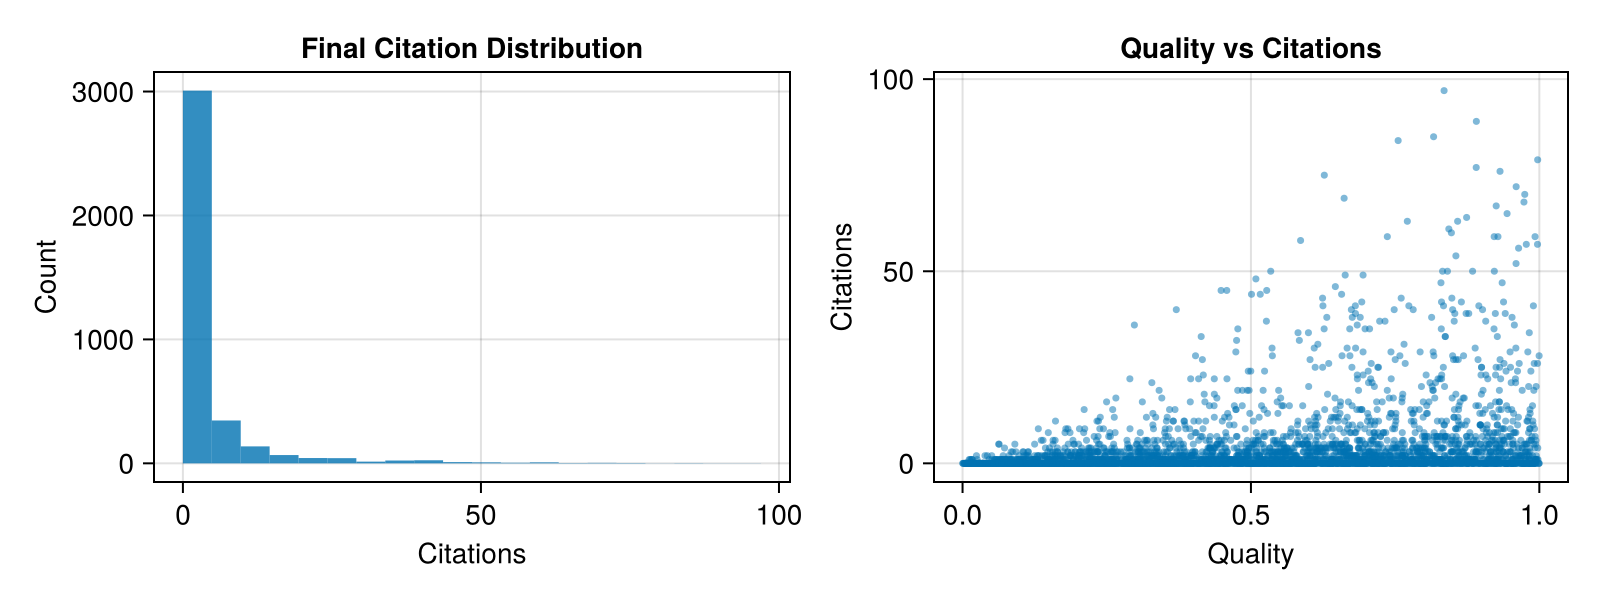

In [27]:
# Get final state
final_data = filter(row -> row.time == n_steps, adf)

# Citation distribution
fig = Figure(resolution=(800, 300))

# Histogram of citations
ax1 = Axis(fig[1, 1], xlabel="Citations", ylabel="Count", title="Final Citation Distribution")
hist!(ax1, final_data.citations, bins=20)

# Quality vs Citations scatter
ax2 = Axis(fig[1, 2], xlabel="Quality", ylabel="Citations", title="Quality vs Citations")
scatter!(ax2, final_data.quality, final_data.citations, markersize=5, alpha=0.5)

fig

In [28]:
# Track citation growth over time
function analyze_citation_patterns(adf)
    # Group by paper ID first, then process each group
    velocities = Dict{Int, Vector{Float64}}()

    # Use groupby to efficiently iterate through papers
    for group in groupby(adf, :id)
        paper_id = first(group.id)

        # Sort by time and get citations
        sorted_times = sort(group, :time)
        citations_over_time = sorted_times.citations

        if length(citations_over_time) > 1
            velocity = diff(citations_over_time)
            velocities[paper_id] = velocity
        end
    end

    return velocities
end

velocities = analyze_citation_patterns(adf)

# Find viral papers (high early velocity)
viral_papers = []
sleeping_beauties = []

for (paper_id, vel) in velocities
    if length(vel) >= 10
        early_velocity = mean(vel[1:min(10, length(vel))])
        late_velocity = mean(vel[max(1, end-10):end])

        if early_velocity > 0.5  # Threshold for "viral"
            push!(viral_papers, paper_id)
        elseif early_velocity < 0.1 && late_velocity > 0.3  # Sleeping beauty pattern
            push!(sleeping_beauties, paper_id)
        end
    end
end

println("Found $(length(viral_papers)) viral papers")
println("Found $(length(sleeping_beauties)) sleeping beauties")

Found 24 viral papers
Found 3 sleeping beauties


### Visualize Citation Trajectories

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/sglyon/.julia/packages/Makie/FUAHr/src/scenes.jl:238


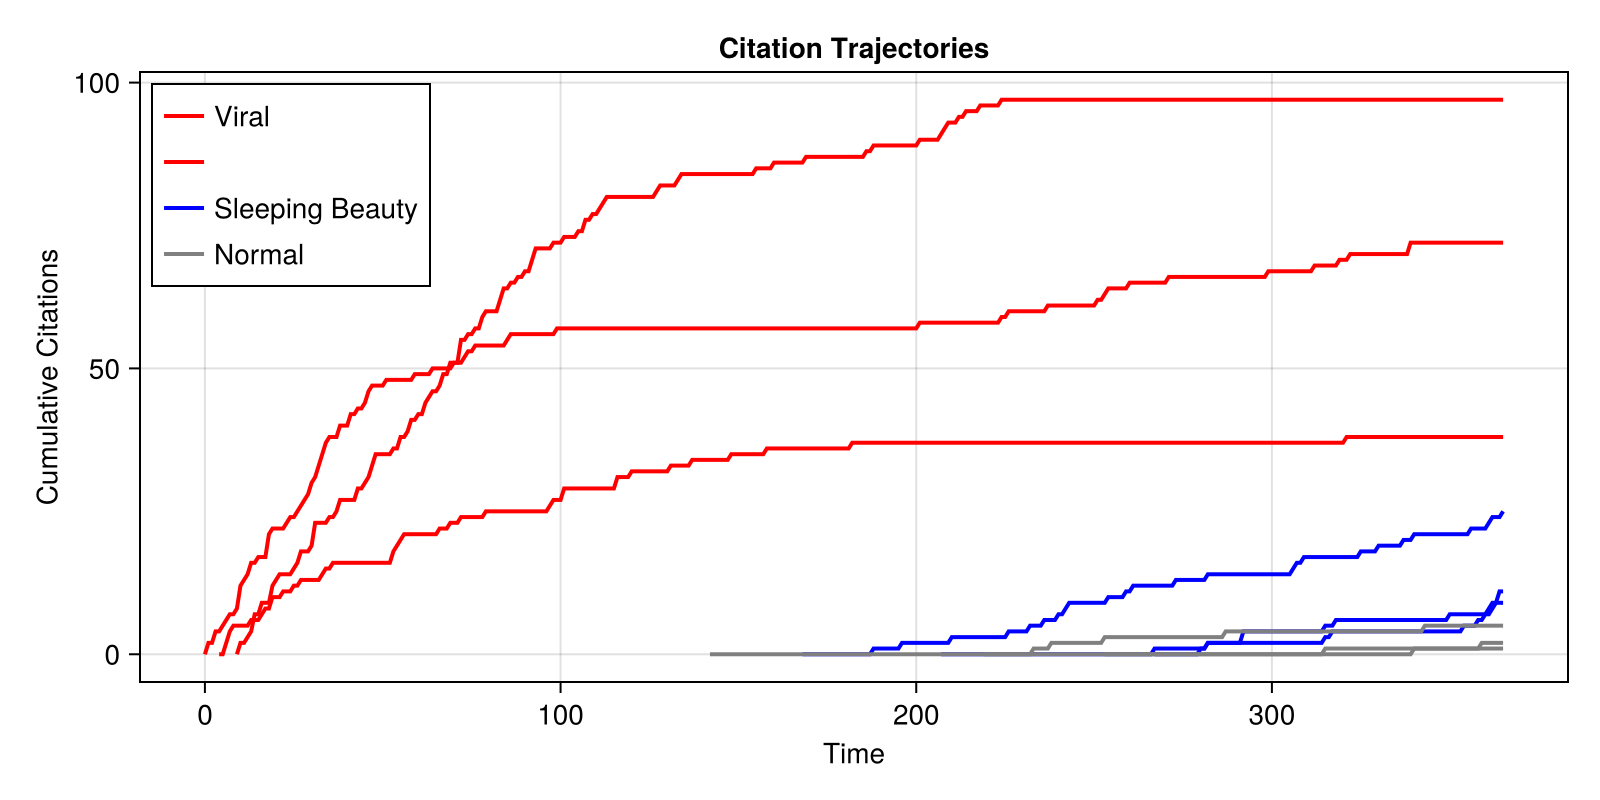

In [29]:
# Plot citation trajectories for different paper types
fig = Figure(resolution=(800, 400))
ax = Axis(fig[1, 1], xlabel="Time", ylabel="Cumulative Citations",
          title="Citation Trajectories")

# Plot a sample of papers
sample_papers = vcat(
    length(viral_papers) > 0 ? viral_papers[1:min(3, length(viral_papers))] : [],
    length(sleeping_beauties) > 0 ? sleeping_beauties[1:min(3, length(sleeping_beauties))] : [],
    rand(setdiff(unique(adf.id), vcat(viral_papers, sleeping_beauties)), min(3, nagents(model)))
)

colors = [:red, :red, :red, :blue, :blue, :blue, :gray, :gray, :gray]
labels = ["Viral", "", "", "Sleeping Beauty", "", "", "Normal", "", ""]

for (i, paper_id) in enumerate(sample_papers)
    paper_data = filter(row -> row.id == paper_id, adf)
    sort!(paper_data, :time)

    if nrow(paper_data) > 0
        lines!(ax, paper_data.time, paper_data.citations,
               color=colors[min(i, length(colors))],
               label=labels[min(i, length(labels))],
               linewidth=2)
    end
end

axislegend(ax, unique=true, position=:lt)
fig

## Part 4: Parameter Calibration from Real Data

In [30]:
# Calibrate model parameters from real citation data
function calibrate_model(citations_df, papers_df)
    # Calculate empirical citation rate
    citation_counts = combine(groupby(citations_df, :cited_paper), nrow => :n_citations)
    mean_citations = mean(citation_counts.n_citations)

    # Calculate field popularity from data
    field_papers = combine(groupby(papers_df, :category), nrow => :count)
    total_papers = sum(field_papers.count)
    field_popularity = Dict(row.category => row.count / total_papers
                          for row in eachrow(field_papers))

    # Calculate author prestige distribution
    author_prestiges = Float64[]
    for paper in eachrow(papers_df)
        if paper.lead_author_id <= nrow(authors_df)
            push!(author_prestiges, authors_df[paper.lead_author_id, :h_index] / 50.0)
        end
    end
    mean_prestige = mean(author_prestiges)

    println("Calibration Results:")
    println("  Mean citations per paper: $(round(mean_citations, digits=2))")
    println("  Mean author prestige: $(round(mean_prestige, digits=3))")
    println("  Field distribution:")
    for (field, pop) in field_popularity
        println("    $field: $(round(pop * 100, digits=1))%")
    end

    return Dict(
        "mean_citations" => mean_citations,
        "field_trends" => field_popularity,
        "mean_prestige" => mean_prestige
    )
end

calibration = calibrate_model(citations_df, papers_df)

Calibration Results:
  Mean citations per paper: 10.95
  Mean author prestige: 0.514
  Field distribution:
    physics: 19.5%
    math: 20.1%
    cs.LG: 19.9%
    cs.AI: 21.0%
    stat.ML: 19.5%


Dict{String, Any} with 3 entries:
  "mean_citations" => 10.9506
  "mean_prestige"  => 0.51396
  "field_trends"   => Dict("physics"=>0.195, "math"=>0.201, "cs.LG"=>0.199, "cs…

## Exercises

1. **Network Effects**: Modify the model to include co-authorship networks. Papers by frequently collaborating authors should have higher visibility.

2. **Conference Boost**: Add "conference" events where papers in certain fields get temporary visibility boosts.

3. **Real Data**: Download the full ArXiv dataset from Kaggle and run the model with real papers. Compare simulated citation patterns to actual ones.

4. **Intervention Analysis**: What happens if we:
   - Increase open access (higher base read probability)?
   - Add social media promotion (viral boost for some papers)?
   - Implement better recommendation systems (quality-based selection)?

## Summary

- Built an ABM of academic paper citations using real data structure
- Observed emergence of power law citation distributions
- Identified viral papers and sleeping beauties
- Model can help understand:
    - How quality vs. marketing affects impact
    - Role of author prestige and networks
    - Effects of field trends on citation patterns